Define colour pallette
Quantize the image to obtain the baseline and compute the average quantization error
Implement FS dithering and compute the average quantization error

In [1]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

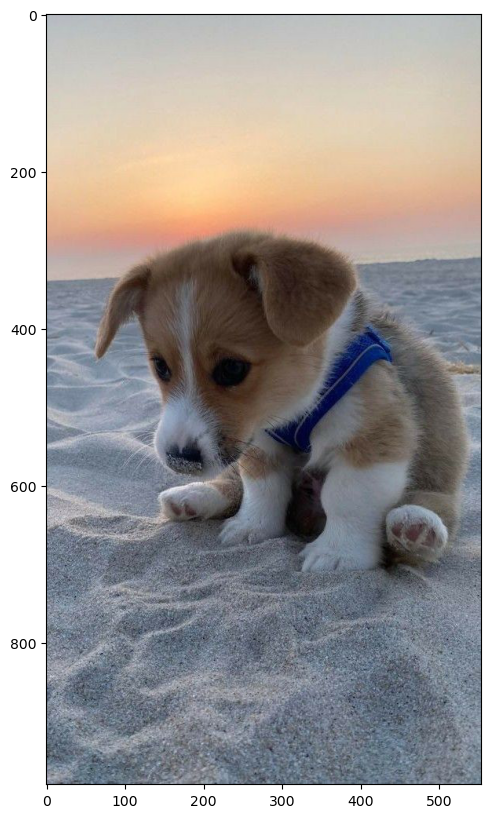

In [2]:
# Load image
img = cv2.imread('dog.jpg')
# Convert it to RGB
rows, cols, channels = img.shape
img_rgb = np.zeros_like(img)

for r in range(rows):
    for c in range(cols):
        pixel = img[r, c, :]
        img_rgb[r, c, 0] = pixel[2]
        img_rgb[r, c, 1] = pixel[1]
        img_rgb[r, c, 2] = pixel[0]
        
plt.imshow(img_rgb)


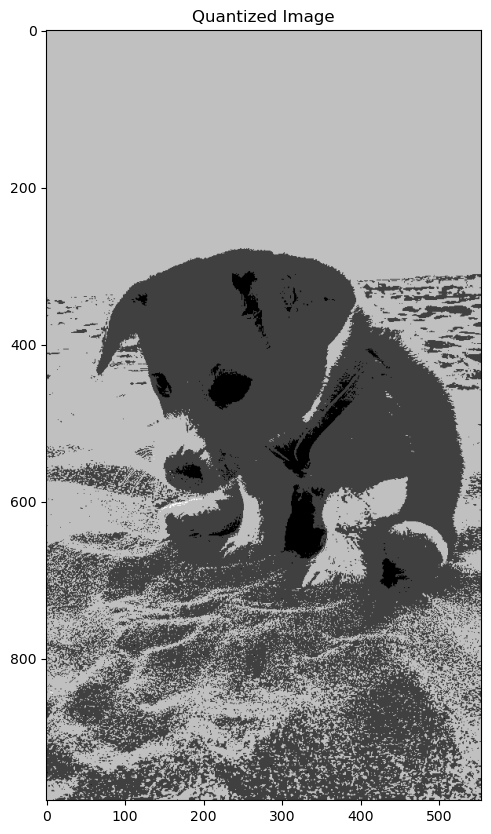

In [3]:
# Black, dark gray, light gray, white
colors = np.array([[0, 0, 0],
                   [64, 64, 64],
                   [192, 192, 192],
                   [255, 255, 255]])
img = img_rgb.astype(np.float32)

# Prepare for quantization
rows, cols, channels = img.shape
quantized = np.zeros_like(img)

# Apply quantization
for r in range(rows):
    for c in range(cols):
        # Extract the original pixel value
        pixel = img[r, c, :]  
        # Find the closest colour from the pallette (using absolute value/Euclidean distance)
        # Note: You may need more than one line of code here
        
        # Compute the Euclidean distance 
        distances = np.linalg.norm(colors - pixel, axis=1)
        
        # Find the index of the closest color in the palette
        closest_color_index = np.argmin(distances)
        
        # Get the corresponding color from the palette
        new_pixel = colors[closest_color_index]
        
        # Apply quantization by replacing the pixel with the closest color
        quantized[r, c, :] = new_pixel

# Cast back to uint8 for display purposes
quantized = quantized.astype(np.uint8)

# Display the quantized image
plt.imshow(quantized)
plt.title('Quantized Image')
plt.show()

In [4]:
# img is already float
quantized_float = quantized.astype(np.float32)

# Compute the Euclidean distance (quantization error) for each pixel
error = np.linalg.norm(img - quantized_float, axis=2) 

# Compute the average quantization error
average_error = np.mean(error)
print(f'average quantization error: {average_error}')

average quantization error: 59.453670501708984


The error diffusion matrix for Floyd-Steinberg dithering:
        X    7/16
3/16    5/16  1/16


(<Axes: >, <matplotlib.image.AxesImage at 0x10f8011fe50>)

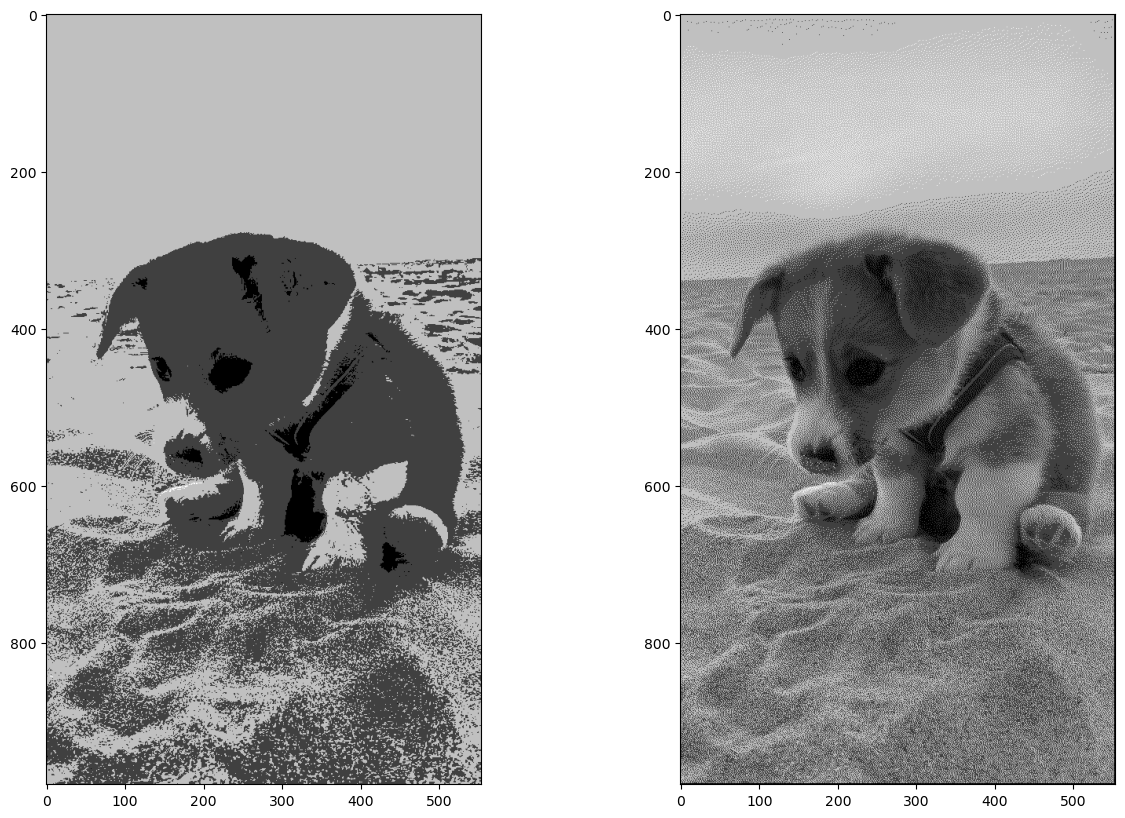

In [5]:
# Floyd-Steinberg Dithering
# Make a temporal copy of the original image, we will need it for error diffusion
img_tmp = np.copy(img)
dithering = np.zeros_like(img)
rows, cols, channels = img.shape

for r in range(1, rows-1):
    for c in range(1, cols-1):
        # Extract the original pixel value
        pixel = img_tmp[r, c, :] 
       # Find the closest color from the palette using Euclidean distance
        distances = np.linalg.norm(colors - pixel, axis=1)
        closest_color_index = np.argmin(distances)
        new_pixel = colors[closest_color_index]
        
        # Apply dithering
        dithering[r, c, :] = new_pixel
        
       # Compute the quantization error (difference between original and quantized pixel)
        error = pixel - new_pixel
        
        # Diffuse the quantization error according to the Floyd-Steinberg diffusion matrix
        if c < cols - 1:
            img_tmp[r, c + 1, :] += error * (7 / 16)
        if r < rows - 1 and c > 0:
            img_tmp[r + 1, c - 1, :] += error * (3 / 16)
        if r < rows - 1:
            img_tmp[r + 1, c, :] += error * (5 / 16)
        if r < rows - 1 and c < cols - 1:
            img_tmp[r + 1, c + 1, :] += error * (1 / 16)
            
# Show quantized image (don't forget to cast back to uint8)
plt.subplot(121), plt.imshow(quantized.astype(np.uint8))   # optimally quantized
plt.subplot(122), plt.imshow(dithering.astype(np.uint8))   # dithering

In [6]:
# Compute average quantization error for dithered image
error = np.linalg.norm(pixel - new_pixel)  
total_error = 0
total_error += error
total_pixels = rows * cols
avg_dith_error = total_error / total_pixels
print(f'avg_dith_error {avg_dith_error}')

avg_dith_error 0.016517455841293983


Which image has higher quantization error? Optimally quantized or dithered?  - in my case average quantization error is higher than avg_dith_error
Which image looks better to you? - in my case dithering image looks better
Can you repeat the same process using only two colours: black and white? Show me :-)

In [ ]:
two_colors = np.array([[0, 0, 0], #black
                          [255, 255, 255]]) #white

img_tmp = np.copy(img)
dithering = np.zeros_like(img)
rows, cols, channels = img.shape

for r in range(1, rows-1):
    for c in range(1, cols-1):
        # Extract the original pixel value
        pixel = img_tmp[r, c, :] 
       # Find the closest color from the palette using Euclidean distance
        distances = np.linalg.norm(two_colors - pixel, axis=1)
        closest_color_index = np.argmin(distances)
        new_pixel = two_colors[closest_color_index]
        
         # Clip the pixel values to be in the valid range [0, 255]
        img_tmp = np.clip(img_tmp, 0, 255)
        # Apply dithering
        dithering[r, c, :] = new_pixel
        
       # Compute the quantization error (difference between original and quantized pixel)
        error = pixel - new_pixel
        
        # Diffuse the quantization error according to the Floyd-Steinberg diffusion matrix
        if c < cols - 1:
            img_tmp[r, c + 1, :] += error * (7 / 16)
        if r < rows - 1 and c > 0:
            img_tmp[r + 1, c - 1, :] += error * (3 / 16)
        if r < rows - 1:
            img_tmp[r + 1, c, :] += error * (5 / 16)
        if r < rows - 1 and c < cols - 1:
            img_tmp[r + 1, c + 1, :] += error * (1 / 16)
            
# Show quantized image (don't forget to cast back to uint8)
plt.subplot(121), plt.imshow(quantized.astype(np.uint8))   # optimally quantized
plt.subplot(122), plt.imshow(dithering.astype(np.uint8))   # dithering